In [1]:
import pandas as pd
import sklearn
import numpy as np
import util
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import seaborn as sns

In [2]:
from sklearn.linear_model import LinearRegression, RidgeCV
import statsmodels.api as sm 
import matplotlib.pylab as plt 
from dmba import regressionSummary, exhaustive_search 
from dmba import adjusted_r2_score, AIC_score, BIC_score
from sklearn.metrics import r2_score
from dmba import backward_elimination, forward_selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import QuantileTransformer, quantile_transform

In [3]:
pd.set_option('max_columns', None)
pd.set_option('max_rows', 81)

In [4]:
ultimate_df = pd.read_csv('Data/Created Datasets/ALL_merge_truncate3.csv', index_col = 0)

In [139]:
# dataset without hazardous dataset - this dataset is bigger

ultimate_df = pd.read_csv('Data/Created Datasets/Impediments_Feature_Count.csv', index_col = 0)

<AxesSubplot:ylabel='Frequency'>

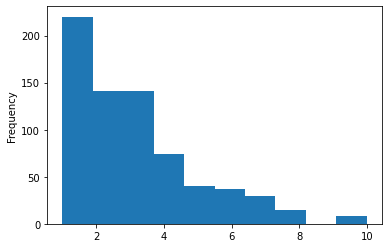

In [147]:
ultimate_df['COUNT'].plot(kind = 'hist')

In [201]:
# capping - removing extreme outliers
#ultimate_df['COUNT'] = ultimate_df[ultimate_df['COUNT'] <= 8]

#ultimate_df['COUNT'] = np.log(ultimate_df['COUNT'])

ultimate_df['COUNT'] = quantile_transform(
    ultimate_df['COUNT'].to_frame(), n_quantiles=500, output_distribution="normal", copy=True
).squeeze()

<AxesSubplot:ylabel='Frequency'>

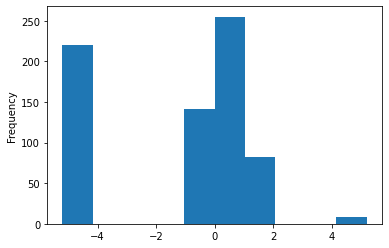

In [202]:
ultimate_df['COUNT'].plot(kind = 'hist')

In [97]:
# only downtown

ultimate_df = ultimate_df[(ultimate_df['LATITUDE'] < 43.6688) & (ultimate_df['LONGITUDE'] > -79.46935) & (ultimate_df['LONGITUDE'] < -79.330700)]

In [6]:
ultimate_df.shape

(921, 20)

In [5]:
# not downtown

ultimate_df = ultimate_df[~((ultimate_df['LATITUDE'] < 43.6688) & (ultimate_df['LONGITUDE'] > -79.46935) & (ultimate_df['LONGITUDE'] < -79.330700))]

In [6]:
ultimate_df.shape

(3030, 20)

In [6]:
ultimate_df['LIGHT'] = ultimate_df['LIGHT'].apply(util.lc)
ultimate_df['TRAFFCTL'] = ultimate_df['TRAFFCTL'].apply(util.tc)
ultimate_df['DRIVACT'] = ultimate_df['DRIVACT'].apply(util.actc)
ultimate_df['DRIVCOND'] = ultimate_df['DRIVCOND'].apply(util.condc)
ultimate_df['VEHTYPE'] = ultimate_df['VEHTYPE'].apply(util.vehc)
ultimate_df['INVAGE'] = ultimate_df['INVAGE'].apply(util.agec)
#ultimate_df['MANOEUVER'] = ultimate_df['MANOEUVER'].apply(util.manc)

In [7]:
ultimate_df = ultimate_df.replace('Yes', 1).replace('<Null>', 0).replace('<Null', 0)

In [8]:
ultimate_df['TIME'] = round(ultimate_df['TIME']/100,3)

In [114]:
X = ultimate_df[[col for col in ultimate_df.columns if col not in ('COUNT', 'WARDNUM', 'LATITUDE', 'LONGITUDE', 'Latitude', 'Longitude')]]
X = pd.get_dummies(X, drop_first = True)
X = sm.add_constant(X)

Y = ultimate_df['COUNT']

In [115]:
model = sm.OLS(Y, X)
results = model.fit()

In [116]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  COUNT   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     3.573
Date:                Wed, 02 Mar 2022   Prob (F-statistic):           3.44e-14
Time:                        18:42:36   Log-Likelihood:                -639.88
No. Observations:                 706   AIC:                             1384.
Df Residuals:                     654   BIC:                             1621.
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                         1.3398      0.710      1.887      0.060      -0.054       2.734
IncidentsTotal                             5.258e-05      0.000      0.200      0.842      -0.000       0.001
SeverityScore                                 1.5153      1.613      0.939      0.348      -1.652       4.682
PercentOfVehicles                             1.4411      1.048      1.375      0.170      -0.618       3.500
AvgAcceleration                               0.0198      0.166      0.119      0.905      -0.306       0.346
TIME                                         -0.0029      0.005     -0.631      0.528      -0.012       0.006
INVAGE_Children                               0.7901      0.687      1.150      0.251      -0.559       2.139
INVAGE_Senior                                -0.0157      0.078     -0.202      0.840      -0.168       0.137
INVAGE_Super Senior                          -0.1055      0.087     -1.218      0.224      -0.276       0.065
INVAGE_Young Adult                           -0.1203      0.068     -1.780      0.076      -0.253       0.012
RDSFCOND_Dry                                 -0.0502      0.335     -0.150      0.881      -0.709       0.609
RDSFCOND_Loose Snow                          -0.2120      0.397     -0.534      0.594      -0.992       0.568
RDSFCOND_Other                               -0.4126      0.429     -0.961      0.337      -1.255       0.430
RDSFCOND_Packed Snow                          0.5457      0.529      1.031      0.303      -0.493       1.585
RDSFCOND_Slush                               -0.3122      0.412     -0.757      0.449      -1.122       0.498
RDSFCOND_Wet                                 -0.1262      0.335     -0.376      0.707      -0.785       0.532
VISIBILITY_Clear                             -0.1791      0.335     -0.535      0.593      -0.837       0.478
VISIBILITY_Fog, Mist, Smoke, Dust            -0.0759      0.673     -0.113      0.910      -1.398       1.246
VISIBILITY_Freezing Rain                     -0.5810      0.493     -1.178      0.239      -1.549       0.387
VISIBILITY_Other                              0.3451      0.429      0.805      0.421      -0.497       1.187
VISIBILITY_Rain                              -0.0018      0.340     -0.005      0.996      -0.668       0.665
VISIBILITY_Snow                              -0.0749      0.368     -0.203      0.839      -0.798       0.648
LIGHT_Dark                                   -0.0952      0.074     -1.283      0.200      -0.241       0.051
LIGHT_Dawn                                    0.7473      0.448      1.668      0.096      -0.132       1.627
LIGHT_Daylight                               -0.0427      0.062     -0.692      0.489      -0.164       0.079
LIG

In [9]:
X = ultimate_df[[col for col in ultimate_df.columns if col not in ('COUNT', 'WARDNUM', 'LATITUDE', 'LONGITUDE', 'Latitude', 'Longitude',  'PercentCar', 'PercentHDT', 'PercentLDT', 'PercentMDT', 'PercentMPV', 'PercentOther', 'VEHTYPE', 'INVAGE')]]

X = pd.get_dummies(X, drop_first = True)

# need to remove the columns with 0s in their names
# the columns with 0 in their names are the ones which are structural zeros/not applicables

#X = X[[col for col in X.columns if '0' not in col]]

In [10]:
X.shape

(706, 44)

In [11]:
Y = ultimate_df['COUNT']

train_X, valid_X, train_Y, valid_Y =  train_test_split(X, Y, test_size = 0.2, random_state = 1)

In [12]:
# Does the model perform better than the null model?
# Our created models must be able to beat this:
# I'm comparing valid_Y to the mean of COUNT. 

regressionSummary(valid_Y, np.repeat(Y.mean(), valid_Y.shape))


Regression statistics

                      Mean Error (ME) : 0.1343
       Root Mean Squared Error (RMSE) : 2.1135
            Mean Absolute Error (MAE) : 1.6914
          Mean Percentage Error (MPE) : -54.8264
Mean Absolute Percentage Error (MAPE) : 86.1793


In [170]:
linear_model = LinearRegression()
linear_model.fit(train_X, train_Y)

LinearRegression()

In [171]:
print(regressionSummary(train_Y, linear_model.predict(train_X)))
regressionSummary(valid_Y, linear_model.predict(valid_X))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 2.4275
            Mean Absolute Error (MAE) : 2.0038
          Mean Percentage Error (MPE) : 88.4475
Mean Absolute Percentage Error (MAPE) : 262.8411
None

Regression statistics

                      Mean Error (ME) : -0.0369
       Root Mean Squared Error (RMSE) : 2.5374
            Mean Absolute Error (MAE) : 2.0727
          Mean Percentage Error (MPE) : 58.4419
Mean Absolute Percentage Error (MAPE) : 217.5977


Estimating transforms: 100%|██████████| 1000/1000 [00:04<00:00, 243.56it/s]


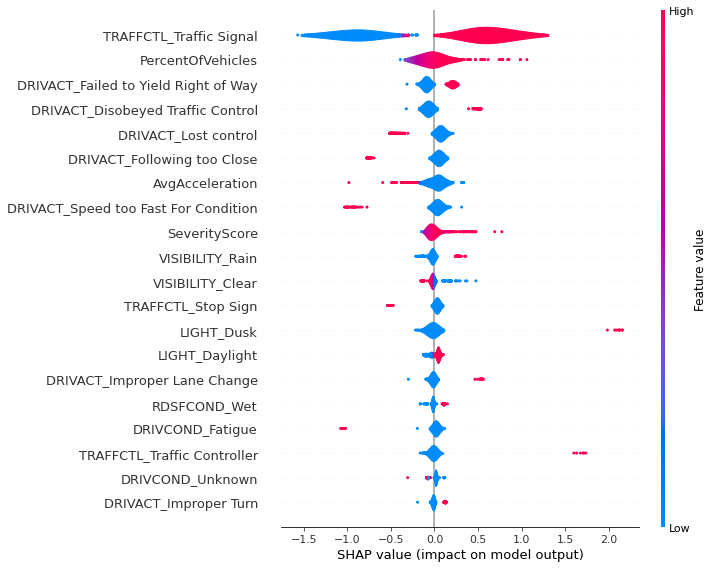

In [172]:
explainer = shap.Explainer(linear_model, masker=shap.maskers.Impute(data= X),
                           feature_names= X.columns, algorithm="linear")
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type = 'violin')

In [173]:
pd.DataFrame({'Actual': valid_Y, 'Predicted': linear_model.predict(valid_X)})

,Actual,Predicted
0,-5.199338,-0.492558
1,-0.225903,-0.161907
2,-5.199338,-3.374658
3,0.720980,-0.025857
4,-5.199338,-3.985122
...,...,...
137,0.720980,-0.493813
138,1.273511,-0.896311
139,0.720980,-0.748796
140,0.282833,-2.845931


<AxesSubplot:>

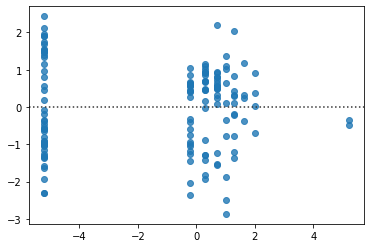

In [174]:
sns.residplot(y = linear_model.predict(valid_X), x = valid_Y)

In [175]:
pd.DataFrame({'Feature': train_X.columns, 'coefficients': linear_model.coef_}).sort_values(by = 'coefficients', ascending = False)

,Feature,coefficients
2,PercentOfVehicles,6.339140e+00
29,TRAFFCTL_Yield Sign,4.042642e+00
34,DRIVACT_Improper Lane Change,3.694042e+00
1,SeverityScore,3.147315e+00
30,DRIVACT_Disobeyed Traffic Control,2.935845e+00
32,DRIVACT_Failed to Yield Right of Way,2.869190e+00
38,DRIVACT_Other,2.834614e+00
31,DRIVACT_Exceeding Speed Limit,2.750602e+00
36,DRIVACT_Improper Turn,2.729062e+00
35,DRIVACT_Improper Passing,2.457787e+00


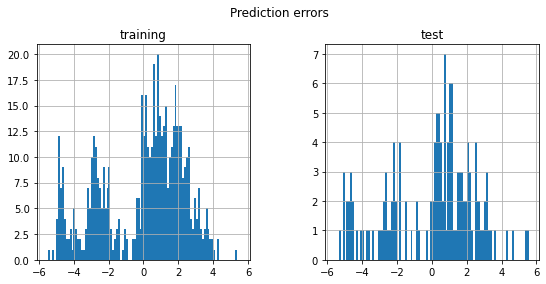

In [176]:
pred_error_train = pd.DataFrame({ 
 'residual': train_Y - linear_model.predict(train_X), 
 'data set': 'training' 
}) 
pred_error_test = pd.DataFrame({ 
 'residual': valid_Y - linear_model.predict(valid_X), 
 'data set': 'test' 
}) 

#boxdata_df = pred_error_train.append(pred_error_test, ignore_index=True) 
fig, axes = plt.subplots(nrows=1, ncols=2) 
fig.set_size_inches(9, 4) 
common = {'bins': 100, 'range': [-pred_error_test['residual'].max(), pred_error_test['residual'].max()]} 
pred_error_train.hist(ax=axes[0], **common) 
pred_error_test.hist(ax=axes[1], **common) 
#boxdata_df.boxplot(ax=axes[2], by = 'data set') 
axes[0].set_title('training') 
axes[1].set_title('test') 
#axes[2].set_title(' ') 
#axes[2].set_ylim(-50, 50) 
plt.suptitle('Prediction errors') 
plt.subplots_adjust(bottom=0.1, top=0.85, wspace=0.35) 
#plt.show() 

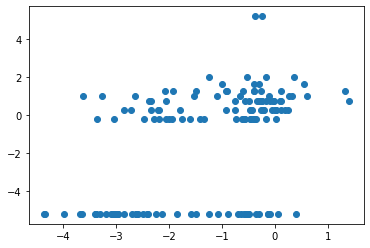

In [179]:
plt.scatter(linear_model.predict(valid_X), valid_Y)

In [177]:
pred_error_train.skew()

residual   -0.463335
dtype: float64

In [178]:
pred_error_test.skew()

residual   -0.456748
dtype: float64

In [181]:
r2_score(valid_Y, linear_model.predict(valid_X))

0.2145525895218685

In [182]:
# these functions assume the existence of a train_Y 
def train_model(variables): 
    if len(variables) == 0: 
        return None 
    model = LinearRegression() 
    model.fit(train_X[variables], train_Y) 
    return model 
    
def score_model(model, variables): 
    if len(variables) == 0: 
        return AIC_score(train_Y, [train_Y.mean()] * len(train_Y), model, df=1) 
    return AIC_score(train_Y, model.predict(train_X[variables]), model) 

In [183]:
forwards_model, best_variables_forward = forward_selection(train_X.columns, train_model, score_model, verbose = True)

Variables: IncidentsTotal, SeverityScore, PercentOfVehicles, AvgAcceleration, TIME, RDSFCOND_Dry, RDSFCOND_Loose Snow, RDSFCOND_Other, RDSFCOND_Packed Snow, RDSFCOND_Slush, RDSFCOND_Wet, VISIBILITY_Clear, VISIBILITY_Fog, Mist, Smoke, Dust, VISIBILITY_Freezing Rain, VISIBILITY_Other, VISIBILITY_Rain, VISIBILITY_Snow, LIGHT_Dark, artificial, LIGHT_Dawn, LIGHT_Dawn, artificial, LIGHT_Daylight, LIGHT_Daylight, artificial, LIGHT_Dusk, LIGHT_Dusk, artificial, TRAFFCTL_Pedestrian Crossover, TRAFFCTL_Stop Sign, TRAFFCTL_Streetcar (Stop for), TRAFFCTL_Traffic Controller, TRAFFCTL_Traffic Signal, TRAFFCTL_Yield Sign, DRIVACT_Disobeyed Traffic Control, DRIVACT_Exceeding Speed Limit, DRIVACT_Failed to Yield Right of Way, DRIVACT_Following too Close, DRIVACT_Improper Lane Change, DRIVACT_Improper Passing, DRIVACT_Improper Turn, DRIVACT_Lost control, DRIVACT_Other, DRIVACT_Speed too Fast For Condition, DRIVACT_Wrong Way on One Way Road, DRIVCOND_Ability Impaired, Alcohol, DRIVCOND_Ability Impaired, 

In [184]:
print(regressionSummary(train_Y, forwards_model.predict(train_X[best_variables_forward])))
regressionSummary(valid_Y, forwards_model.predict(valid_X[best_variables_forward]))


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 2.4615
            Mean Absolute Error (MAE) : 2.0367
          Mean Percentage Error (MPE) : 91.8719
Mean Absolute Percentage Error (MAPE) : 259.7017
None

Regression statistics

                      Mean Error (ME) : -0.0280
       Root Mean Squared Error (RMSE) : 2.6004
            Mean Absolute Error (MAE) : 2.1666
          Mean Percentage Error (MPE) : 61.3705
Mean Absolute Percentage Error (MAPE) : 225.3142


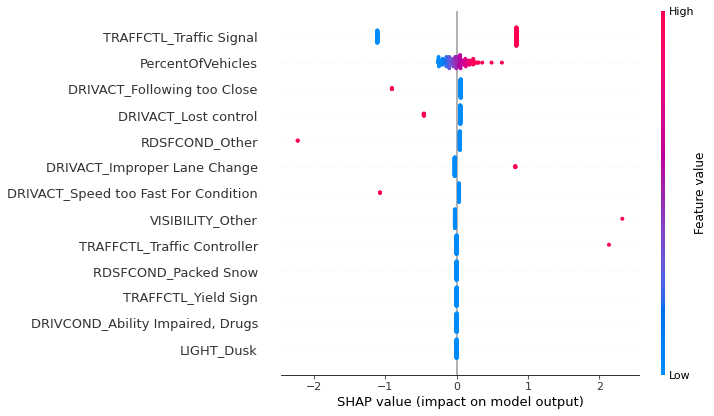

In [185]:
masker = shap.maskers.Independent(data= valid_X[best_variables_forward])
explainer = shap.Explainer(forwards_model, masker= masker,
                           feature_names= valid_X[best_variables_forward].columns, algorithm="linear")
shap_values = explainer.shap_values(valid_X[best_variables_forward])
shap.summary_plot(shap_values, valid_X[best_variables_forward])

In [186]:
pd.DataFrame({'Feature': best_variables_forward, 'coefficients': forwards_model.coef_}).sort_values(by = 'coefficients', ascending = False)

,Feature,coefficients
9,PercentOfVehicles,6.586884
2,"DRIVCOND_Ability Impaired, Drugs",4.790421
8,TRAFFCTL_Yield Sign,3.921586
10,RDSFCOND_Packed Snow,2.695195
11,VISIBILITY_Other,2.348497
1,LIGHT_Dusk,2.245773
4,TRAFFCTL_Traffic Controller,2.137721
0,TRAFFCTL_Traffic Signal,1.951123
5,DRIVACT_Improper Lane Change,0.848349
7,DRIVACT_Lost control,-0.510266


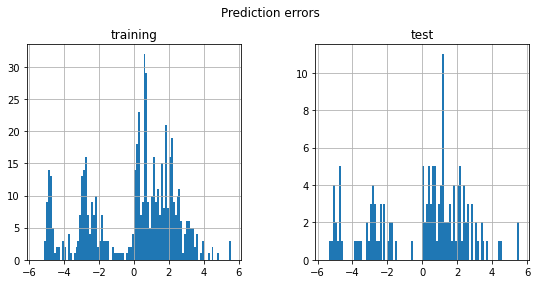

In [187]:
pred_error_train = pd.DataFrame({ 
 'residual': train_Y - forwards_model.predict(train_X[best_variables_forward]), 
 'data set': 'training' 
}) 
pred_error_test = pd.DataFrame({ 
 'residual': valid_Y - forwards_model.predict(valid_X[best_variables_forward]), 
 'data set': 'test' 
}) 

#boxdata_df = pred_error_train.append(pred_error_test, ignore_index=True) 
fig, axes = plt.subplots(nrows=1, ncols=2) 
fig.set_size_inches(9, 4) 
common = {'bins': 100, 'range': [-pred_error_test['residual'].max(), pred_error_test['residual'].max()]} 
pred_error_train.hist(ax=axes[0], **common) 
pred_error_test.hist(ax=axes[1], **common) 
#boxdata_df.boxplot(ax=axes[2], by = 'data set') 
axes[0].set_title('training') 
axes[1].set_title('test') 
#axes[2].set_title(' ') 
#axes[2].set_ylim(-50, 50) 
plt.suptitle('Prediction errors') 
plt.subplots_adjust(bottom=0.1, top=0.85, wspace=0.35) 
#plt.show() 

In [188]:
pred_error_train.skew()

residual   -0.478474
dtype: float64

In [189]:
pred_error_test.skew()

residual   -0.47489
dtype: float64

<AxesSubplot:>

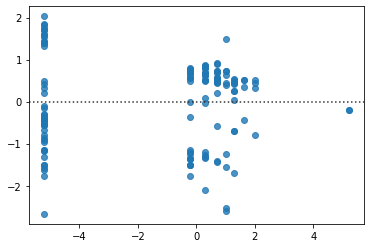

In [190]:
sns.residplot(y = forwards_model.predict(valid_X[best_variables_forward]), x = valid_Y)

In [191]:
backwards_model, best_variables_backward = backward_elimination(train_X.columns, train_model, score_model, verbose = False)

In [192]:
print(regressionSummary(train_Y, backwards_model.predict(train_X[best_variables_backward])))
regressionSummary(valid_Y, backwards_model.predict(valid_X[best_variables_backward]))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 2.4505
            Mean Absolute Error (MAE) : 2.0207
          Mean Percentage Error (MPE) : 90.4482
Mean Absolute Percentage Error (MAPE) : 257.1592
None

Regression statistics

                      Mean Error (ME) : -0.0218
       Root Mean Squared Error (RMSE) : 2.5154
            Mean Absolute Error (MAE) : 2.1003
          Mean Percentage Error (MPE) : 67.6783
Mean Absolute Percentage Error (MAPE) : 217.1787


In [193]:
pd.DataFrame({'Feature': best_variables_backward, 'coefficients': backwards_model.coef_}).sort_values(by = 'coefficients', ascending = False)

,Feature,coefficients
11,DRIVACT_Improper Lane Change,4.547911
9,DRIVACT_Failed to Yield Right of Way,3.890631
7,DRIVACT_Disobeyed Traffic Control,3.859174
6,TRAFFCTL_Yield Sign,3.851062
15,DRIVACT_Other,3.795266
13,DRIVACT_Improper Turn,3.739168
8,DRIVACT_Exceeding Speed Limit,3.530865
12,DRIVACT_Improper Passing,3.455450
14,DRIVACT_Lost control,3.160416
10,DRIVACT_Following too Close,2.886132


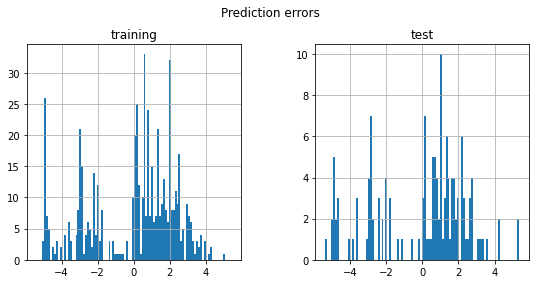

In [194]:
pred_error_train = pd.DataFrame({ 
 'residual': train_Y - backwards_model.predict(train_X[best_variables_backward]), 
 'data set': 'training' 
}) 
pred_error_test = pd.DataFrame({ 
 'residual': valid_Y - backwards_model.predict(valid_X[best_variables_backward]), 
 'data set': 'test' 
}) 

#boxdata_df = pred_error_train.append(pred_error_test, ignore_index=True) 
fig, axes = plt.subplots(nrows=1, ncols=2) 
fig.set_size_inches(9, 4) 
common = {'bins': 100, 'range': [-pred_error_test['residual'].max(), pred_error_test['residual'].max()]} 
pred_error_train.hist(ax=axes[0], **common) 
pred_error_test.hist(ax=axes[1], **common) 
#boxdata_df.boxplot(ax=axes[2], by = 'data set') 
axes[0].set_title('training') 
axes[1].set_title('test') 
#axes[2].set_title(' ') 
#axes[2].set_ylim(-50, 50) 
plt.suptitle('Prediction errors') 
plt.subplots_adjust(bottom=0.1, top=0.85, wspace=0.35) 
#plt.show() 

<AxesSubplot:>

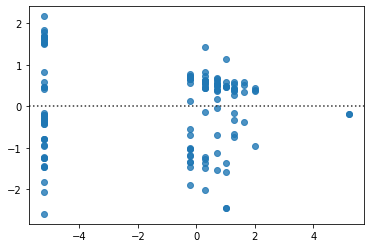

In [195]:
sns.residplot(y = backwards_model.predict(valid_X[best_variables_backward]), x = valid_Y)

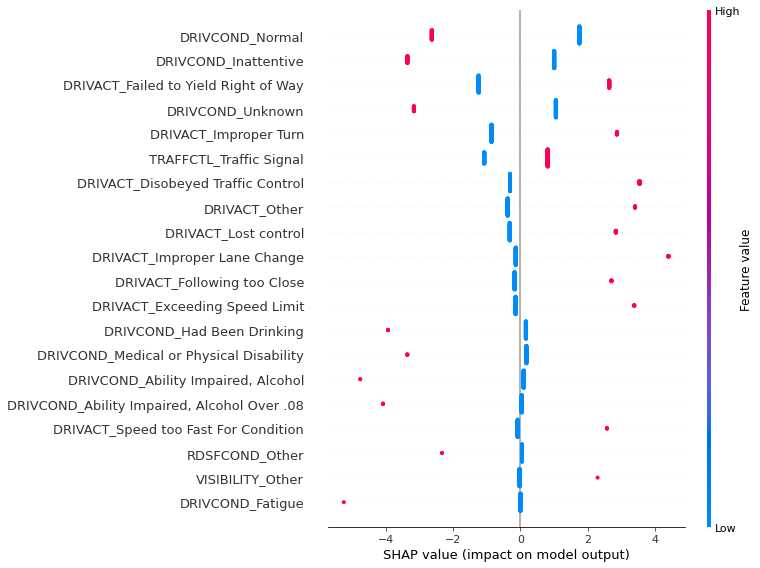

In [196]:
masker = shap.maskers.Independent(data= valid_X[best_variables_backward])
explainer = shap.Explainer(backwards_model, masker= masker,
                           feature_names= valid_X[best_variables_backward].columns, algorithm="linear")
shap_values = explainer.shap_values(valid_X[best_variables_backward])
shap.summary_plot(shap_values, valid_X[best_variables_backward])

In [13]:
ridge_model = RidgeCV()
ridge_model.fit(train_X, train_Y)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [20]:
print(regressionSummary(train_Y, ridge_model.predict(train_X)))
regressionSummary(valid_Y, ridge_model.predict(valid_X))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1.8030
            Mean Absolute Error (MAE) : 1.4004
          Mean Percentage Error (MPE) : -44.5776
Mean Absolute Percentage Error (MAPE) : 70.3286
None

Regression statistics

                      Mean Error (ME) : 0.0023
       Root Mean Squared Error (RMSE) : 2.1073
            Mean Absolute Error (MAE) : 1.6027
          Mean Percentage Error (MPE) : -50.5866
Mean Absolute Percentage Error (MAPE) : 78.6771


<AxesSubplot:xlabel='COUNT'>

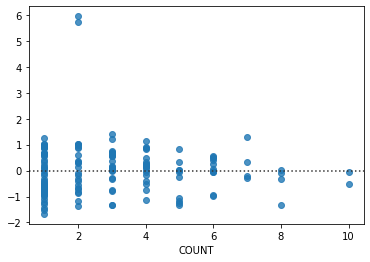

In [16]:
sns.residplot(y = ridge_model.predict(valid_X), x = valid_Y)

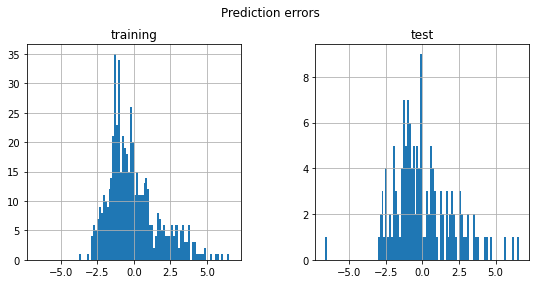

In [17]:
pred_error_train = pd.DataFrame({ 
 'residual': train_Y - ridge_model.predict(train_X), 
 'data set': 'training' 
}) 
pred_error_test = pd.DataFrame({ 
 'residual': valid_Y - ridge_model.predict(valid_X), 
 'data set': 'test' 
}) 

#boxdata_df = pred_error_train.append(pred_error_test, ignore_index=True) 
fig, axes = plt.subplots(nrows=1, ncols=2) 
fig.set_size_inches(9, 4) 
common = {'bins': 100, 'range': [-pred_error_test['residual'].max(), pred_error_test['residual'].max()]} 
pred_error_train.hist(ax=axes[0], **common) 
pred_error_test.hist(ax=axes[1], **common) 
#boxdata_df.boxplot(ax=axes[2], by = 'data set') 
axes[0].set_title('training') 
axes[1].set_title('test') 
#axes[2].set_title(' ') 
#axes[2].set_ylim(-50, 50) 
plt.suptitle('Prediction errors') 
plt.subplots_adjust(bottom=0.1, top=0.85, wspace=0.35) 
#plt.show() 

In [18]:
pred_error_train.skew()

residual    1.055165
dtype: float64

In [19]:
pred_error_test.skew()

residual    0.390395
dtype: float64